In [1]:
import loompy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import os
from cytograph.pipeline import load_config, PunchcardDeck
from cytograph.plotting import colorize
from cytograph.embedding import art_of_tsne
from cytograph.visualization import scatterm
from cytograph.species import Species
from urllib.request import urlretrieve
from sknetwork.hierarchy import cut_straight
import scipy.cluster.hierarchy as hc
import numpy_groupies as npg
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy import sparse
import seaborn
import matplotlib as mpl
import gget
import pickle
import networkx as nx
from umap import UMAP
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import NMF, PCA

# suppress INFO
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

# colors for ROI Groups
region_color_dict = dict(
    zip(
        ["Cerebral cortex", "Hippocampus", "Cerebral nuclei", "Hypothalamus", "Thalamus", "Midbrain", "Pons", "Cerebellum", "Myelencephalon", "Spinal cord"],
        ['#4682f0', '#8eb7d1', '#89d8e0', '#f28e37', '#e7bc1f', '#43ad78', '#a7236e', '#ed5f8e', '#955ba5', '#eec2a4']
    )
)

In [2]:
folder = '/proj/human_adult/20220222/harmony/paris_top_bug/data/'
figure_folder = '/home/kimberly/figures/revision'

In [3]:
cbl = seaborn.color_palette('colorblind')
cbl

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [4]:
def clean_roi(roi_attr):
    return pd.Series(roi_attr).replace({r'[^\x00-\x7F]+':''}, regex=True).to_numpy()

# Supercluster names and files

In [5]:
superclusters = np.array(
    [
        'Upper-layer IT', 'Deep-layer IT', 'Deep-layer NP', 'Deep-layer 6CT/b',
        'MGE interneuron', 'CGE interneuron', 'LAMP5-LHX6 and Chandelier', 'Miscellaneous',
        'Hippocampus CA1-3', 'Hippocampus CA4', 'Hippocampus DG', 'Amygdala excitatory', 
        'Medium spiny neuron (MSN)', 'Eccentric MSN', 'Splatter',
        'Mammillary body', 'Thalamic excitatory', 'Midbrain-derived inhibitory', 
        'Upper rhombic lip', 'Cerebellar inhibitory', 'Lower rhombic lip',  
    ][::-1]
)

In [6]:
A_names = {
    'harmony_A_A': 'Splatter',
    'harmony_A_B': 'Deep-layer IT',
    'harmony_A_C_Clean': 'Upper-layer IT', 
    'harmony_A_D': 'Amygdala excitatory',
    'harmony_A_E_Clean': 'Miscellaneous',
    'harmony_A_F_Clean': 'MGE interneuron', 
    'harmony_A_G_Clean': 'CGE interneuron', 
    'harmony_A_H_Clean': 'Thalamic excitatory',
    'harmony_A_I_Clean': 'Deep-layer 6CT/b', 
    'harmony_A_J_Clean': 'Medium spiny neuron (MSN)', 
    'harmony_A_K_Clean_Clean': 'Upper rhombic lip', 
    'harmony_A_L_Clean': 'Cerebellar inhibitory', 
    'harmony_A_M': 'Hippocampus CA1-3', 
    'harmony_A_N_Clean_Clean': 'LAMP5-LHX6 and Chandelier', 
    'harmony_A_O_Clean': 'Hippocampus DG', 
    'harmony_A_P_Clean': 'Hippocampus CA4', 
    'harmony_A_Q_Clean': 'Eccentric MSN', 
    'harmony_A_R_Clean': 'Deep-layer NP', 
    'harmony_A_S_Clean': 'Midbrain-derived inhibitory',
    'harmony_A_T': 'Mammillary body',
    'harmony_A_U': 'Lower rhombic lip'  
}

In [7]:
supercluster_dict = dict(zip(list(A_names.values()), list(A_names.keys())))

# Supercluster proportions by dissection (Fig. 2A)

##### Make and save an ordered table of dissections and their regions

In [8]:
with loompy.connect('/proj/human_adult/20220222/harmony/new_embeddings/data/harmony_A.loom') as ds:
    tissue = pd.Series(ds.ca.Tissue).str.split('(').str[0].str.split('-').str[0].str.strip().str.lower().str.capitalize()
    print(tissue.unique())


['Myelencephalon' 'Pons' 'Cerebellum' 'Midbrain' 'Thalamus' 'Hypothalamus'
 'Spinal cord' 'Basal forebrain' 'Body of hippocampus' 'Basal nuclei'
 'Amygdaloid complex' 'Cerebral cortex' 'Head of hippocampus'
 'Tail of hippocampus' 'Epithalamus' 'Extended amygdala' 'Paleocortex'
 'Claustrum' 'Perirhinal cortex']


In [9]:
with loompy.connect('/proj/human_adult/20220222/harmony/new_embeddings/data/harmony_A.loom') as ds:

    roi_grp_attr = tissue.to_numpy()
    roi_grp_attr[tissue == 'Epithalamus'] = 'Thalamus'
    roi_grp_attr[tissue.str.contains('hippocampus')] = 'Hippocampus'
    roi_grp_attr[tissue == 'Paleocortex'] = 'Cerebral cortex'
    roi_grp_attr[tissue == 'Perirhinal cortex'] = 'Cerebral cortex'
    
    roi_group_dict = dict(zip(ds.ca.Roi, roi_grp_attr))
    
np.unique(roi_grp_attr)

array(['Amygdaloid complex', 'Basal forebrain', 'Basal nuclei',
       'Cerebellum', 'Cerebral cortex', 'Claustrum', 'Extended amygdala',
       'Hippocampus', 'Hypothalamus', 'Midbrain', 'Myelencephalon',
       'Pons', 'Spinal cord', 'Thalamus'], dtype=object)

In [10]:
roi_grp_order = [
        'Cerebral cortex',
        'Hippocampus',
        'Claustrum',
        'Amygdaloid complex',
        'Extended amygdala',
        'Basal nuclei',
        'Basal forebrain',
        'Hypothalamus',
        'Thalamus', 
        'Midbrain',
        'Cerebellum',
        'Pons',
        'Myelencephalon',
        'Spinal cord'
    ]

np.all([x in roi_grp_order for x in np.unique(roi_grp_attr)])


True

In [11]:
with loompy.connect('/proj/human_adult/20220222/harmony/new_embeddings/data/harmony_A.loom', 'r') as ds:
    
    df = pd.DataFrame.from_dict(roi_group_dict, orient='index', columns=['ROI Group'])
    df.reset_index(inplace=True)
    order = dict(zip(roi_grp_order, range(len(roi_grp_order))))
    df['Order'] = [order.get(x) for x in df['ROI Group']]
    df.sort_values(by=['Order', 'index'], inplace=True)
    
    df['ROI Group Coarse'] = df['ROI Group']
    df['ROI Group Coarse'][df['ROI Group'].isin(['Claustrum', 'Basal nuclei','Basal forebrain', 'Amygdaloid complex', 'Extended amygdala'])] = 'Cerebral nuclei'
                           
df.head()


/var/lib/condor/execute/dir_438759/ipykernel_613958/2004050432.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ROI Group Coarse'][df['ROI Group'].isin(['Claustrum', 'Basal nuclei','Basal forebrain', 'Amygdaloid complex', 'Extended amygdala'])] = 'Cerebral nuclei'


,index,ROI Group,Order,ROI Group Coarse
78,Human A13,Cerebral cortex,0,Cerebral cortex
81,Human A14,Cerebral cortex,0,Cerebral cortex
45,Human A19,Cerebral cortex,0,Cerebral cortex
68,Human A1C,Cerebral cortex,0,Cerebral cortex
61,Human A23,Cerebral cortex,0,Cerebral cortex


In [12]:
df.shape

(106, 4)

In [13]:
df.to_csv('roi_group_table.csv')

##### Plot supercluster proportions by dissection

In [14]:
# get supercluster labels by pool

with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.Punchcard))

with loompy.connect('/proj/human_adult/20220222/harmony/new_embeddings/data/harmony_A.loom', 'r') as ds:
    punchcard_attr = np.array([cell_dict.get(x) for x in ds.ca.CellID])
    labels = np.ones(ds.shape[1]).astype('int')
    for pun in np.unique(punchcard_attr):
        ix = punchcard_attr == pun
        name = A_names[pun]
        labels[ix] = np.where(superclusters == name)[0]
labels

array([ 2,  2,  2, ..., 13, 13, 13])

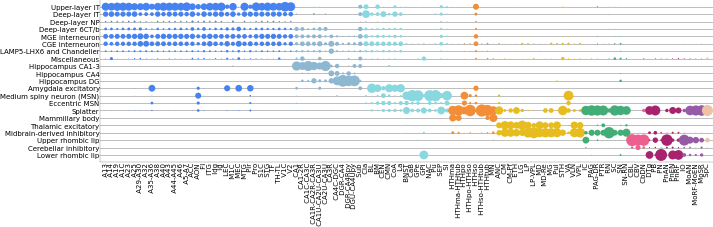

In [109]:
plt.figure(None, (11, 3))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/new_embeddings/data/harmony_A.loom', 'r') as ds:
        
    # get ROIs and order by ROI Groups
    rois = df['index'].to_numpy()
    total_counts = np.array([(ds.ca.Roi == r).sum() for r in rois])
    # remove rois with no neurons (A35r)
    rois = rois[total_counts > 50]
    total_counts = total_counts[total_counts > 50]

    # use superclusters and labels from previous cell
    
    roi_counts = []
    x = []
    y = []
    colors = []
    for i, r in enumerate(rois):
        # get fraction of dissection that belongs to each label
        agg = npg.aggregate(labels, ds.ca.Roi == r) / total_counts[i]
        roi_counts.append(agg)
        x.append( [i] * len(superclusters) )
        y.append( range(len(superclusters)) )
        c = region_color_dict[df.query('index == @r')['ROI Group Coarse'].values[0]]
        colors = colors + [c] * len(superclusters)

    # convert lists to matrices 
    roi_counts = np.hstack(roi_counts)
    x = np.hstack(x)
    y = np.hstack(y)

    # scatter plot
    plt.scatter(x, y, s=roi_counts * 150, c=colors, rasterized=False, lw=0)
    plt.grid(axis='y')
    ax.set_axisbelow(True)
    ax.tick_params(length=0)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.xticks(range(len(rois)), pd.Series(rois).str.replace('Human', ''), rotation=90, fontsize=7)
    plt.yticks(range(len(superclusters)), superclusters, fontsize=7)
    plt.margins(0.01, 0.05)
    
    # plt.savefig(f'{figure_folder}/harmony_A_regions.pdf', dpi=300)

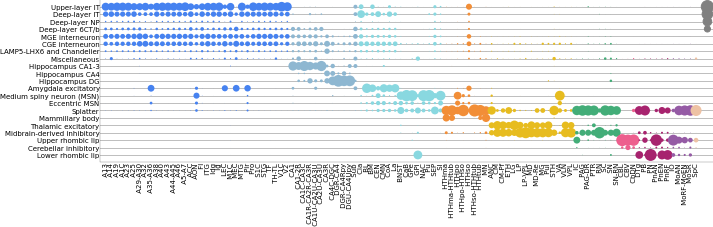

In [16]:
plt.figure(None, (11, 3))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/new_embeddings/data/harmony_A.loom', 'r') as ds:
        
    # get ROIs and order by ROI Groups
    rois = df['index'].to_numpy()
    total_counts = np.array([(ds.ca.Roi == r).sum() for r in rois])
    # remove rois with no neurons (A35r)
    rois = rois[total_counts > 50]
    total_counts = total_counts[total_counts > 50]

    # use superclusters and labels from previous cell
    
    roi_counts = []
    x = []
    y = []
    colors = []
    for i, r in enumerate(rois):
        # get fraction of dissection that belongs to each label
        agg = npg.aggregate(labels, ds.ca.Roi == r) / total_counts[i]
        roi_counts.append(agg)
        x.append( [i] * len(superclusters) )
        y.append( range(len(superclusters)) )
        c = region_color_dict[df.query('index == @r')['ROI Group Coarse'].values[0]]
        colors = colors + [c] * len(superclusters)

    # convert lists to matrices 
    roi_counts = np.hstack(roi_counts)
    x = np.hstack(x)
    y = np.hstack(y)

    # scatter plot
    plt.scatter(x, y, s=roi_counts * 150, c=colors, rasterized=False, lw=0)
    plt.grid(axis='y')
    ax.set_axisbelow(True)
    ax.tick_params(length=0)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.xticks(range(len(rois)), pd.Series(rois).str.replace('Human', ''), rotation=90, fontsize=7)
    plt.yticks(range(len(superclusters)), superclusters, fontsize=7)
    plt.margins(0.01, 0.05)
    
    # add key
    plt.scatter([106]*4, [17, 18, 19, 20], s=np.array([0.25, 0.50, 0.75, 1]) * 150, c='grey')
    
    plt.savefig(f'{figure_folder}/harmony_A_regions_with_key.pdf', dpi=300)

# Explore anatomical variation with superclusters and dissections

In [17]:
def calc_comp(pool_file, rois, cluster_set=None, min_cells=100, drop_zeros=False, verbose=False):

    with loompy.connect(pool_file, 'r') as ds:
        
        if cluster_set is None:
            # use neurons only
            cells = pd.Series(ds.ca.Punchcard).str.startswith('harmony_A_').to_numpy()
            # get cluster set
            cluster_set = np.unique(ds.ca.Clusters[cells])
            # drop immune
            immune_clusters = [457, 458, 459, 460] # 0, 1, 2, 3 if using Euclidean order
            cluster_set = cluster_set[~np.isin(cluster_set, immune_clusters)]
            
        # get cluster and roi attr 
        roi_attr = clean_roi(ds.ca.Roi)
        clusters = ds.ca.Clusters

        # get number of clusters
        n_clusters = len(cluster_set)
        if verbose:
            print(f'Using {len(rois)} dissections: {rois}')
            print(f'Using {n_clusters} clusters: {cluster_set}')

        # empty matrix for storing cluster composition
        comp_mat = np.zeros((len(rois), n_clusters))
        # empty matrix for tracking which dissections are skipped
        skipped = np.ones(len(rois)).astype('bool')
        for i, r in enumerate(rois):
            # how many cells are in the subset from this dissection?
            selected = roi_attr == r
            norm = (selected & np.isin(clusters, cluster_set)).sum()
            # exclude dissection if fewer than min cells
            if norm >= min_cells:
                # loop through cluster_set, counting each cluster in the selected cells
                # normalize by total cells in the subset from this dissection
                comp_mat[i, :] = np.array([(clusters[selected] == cluster_set[i]).sum() for i in range(n_clusters)]) / norm
                skipped[i] = False
    
        # rows should sum to 1
        assert np.allclose(np.sum(comp_mat[~skipped], axis=1), 1)
        # matrix should still be the same shape
        assert comp_mat.shape == (len(rois), n_clusters)
        
        # if specified, drop clusters where the count is now 0
        if drop_zeros:
            comp_mat = comp_mat[:, np.count_nonzero(comp_mat, axis=0) > 0]

        return comp_mat

In [18]:
def plot_spring_graph(comp_mat, rois, n_neighbors, k=None, edge_scale=2, node_color='lightblue'):
    
    # calculate nearest dissections based on correlation
    neigh = NearestNeighbors(n_neighbors=n_neighbors + 1, metric='correlation')
    neigh.fit(comp_mat)
    knn = neigh.kneighbors_graph(comp_mat, mode='distance')
    # exclude self
    knn.setdiag(0)

    # create a graph from knn
    G = nx.from_numpy_array(knn)
    # relabel nodes with dissection names
    nx.relabel_nodes(
        G, 
        dict(zip(range(len(rois)), pd.Series(rois).str.replace('Human ', ''))),
        copy=False)

    # get edge weights and scale
    # subtract 1 from correlation to get a distance
    weights = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    edge_weight = np.divide(
        1 - np.clip(weights, 0, 1),
        edge_scale
    )

    pos = nx.spring_layout(G, k=k)
    nx.draw(G, pos=pos, with_labels=True, font_size=10, width=edge_weight, node_color=node_color)
    
    return knn

# Calculate cluster-composition matrices for each supercluster

In [19]:
# save region for every dissection to a dictionary
with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/Pool.loom', 'r') as ds:
    roi_group_dict = dict(zip(clean_roi(ds.ca.Roi), ds.ca.ROIGroupCoarse))

In [20]:
pool_file = '/proj/human_adult/20220222/harmony/paris_top_bug/data/Pool.loom'

comp_mat_dict = {}
roi_dict = {}
min_cells = 100

for name in superclusters:
    
    print(f"\n{name}")
    subset = supercluster_dict[name]

    # get clusters and rois for this subset
    with loompy.connect(pool_file, 'r') as ds:
        cluster_set = np.unique(ds.ca.Clusters[ds.ca.Punchcard == subset])
        # drop immune if miscellaneous
        if name == 'Miscellaneous':
            immune_clusters = [457, 458, 459, 460] # 0, 1, 2, 3 if using Euclidean order
            cluster_set = cluster_set[~np.isin(cluster_set, immune_clusters)]
        cells = np.isin(ds.ca.Clusters, cluster_set)
        # include only dissections with at least min cells
        rois, counts = np.unique(clean_roi(ds.ca.Roi[cells]), return_counts=True)
        rois = rois[counts > min_cells]

    # calc composition matrix
    comp_mat = calc_comp(
        pool_file, 
        rois=rois,
        cluster_set=cluster_set,
        verbose=True
    )

    # save matrix and rois
    comp_mat_dict[name] = comp_mat
    roi_dict[name] = rois


Lower rhombic lip
Using 11 dissections: ['Human DTg' 'Human GPi' 'Human IO' 'Human MoAN' 'Human MoRF-MoEN'
 'Human MoSR' 'Human PB' 'Human PN' 'Human PnEN' 'Human PnRF' 'Human SN']
Using 8 clusters: [ 8  9 10 11 12 13 14 15]

Cerebellar inhibitory
Using 12 dissections: ['Human CBL' 'Human CBV' 'Human CbDN' 'Human DTg' 'Human IC' 'Human IO'
 'Human MoAN' 'Human MoSR' 'Human PB' 'Human PnAN' 'Human PnEN'
 'Human PnRF']
Using 10 clusters: [133 134 135 136 137 138 139 140 141 142]

Upper rhombic lip
Using 17 dissections: ['Human CBL' 'Human CBV' 'Human CbDN' 'Human DTg' 'Human GPe' 'Human IC'
 'Human IO' 'Human MoAN' 'Human MoRF-MoEN' 'Human MoSR' 'Human PAG-DR'
 'Human PB' 'Human PN' 'Human PnAN' 'Human PnEN' 'Human PnRF' 'Human SpC']
Using 6 clusters: [  0   1   2   3   4 410]

Midbrain-derived inhibitory
Using 34 dissections: ['Human ANC' 'Human BNST' 'Human CM' 'Human CM-Pf' 'Human DTg' 'Human ETH'
 'Human HTHma' 'Human HTHma-HTHtub' 'Human HTHpo-HTHso' 'Human HTHtub'
 'Human IC' 'Hum

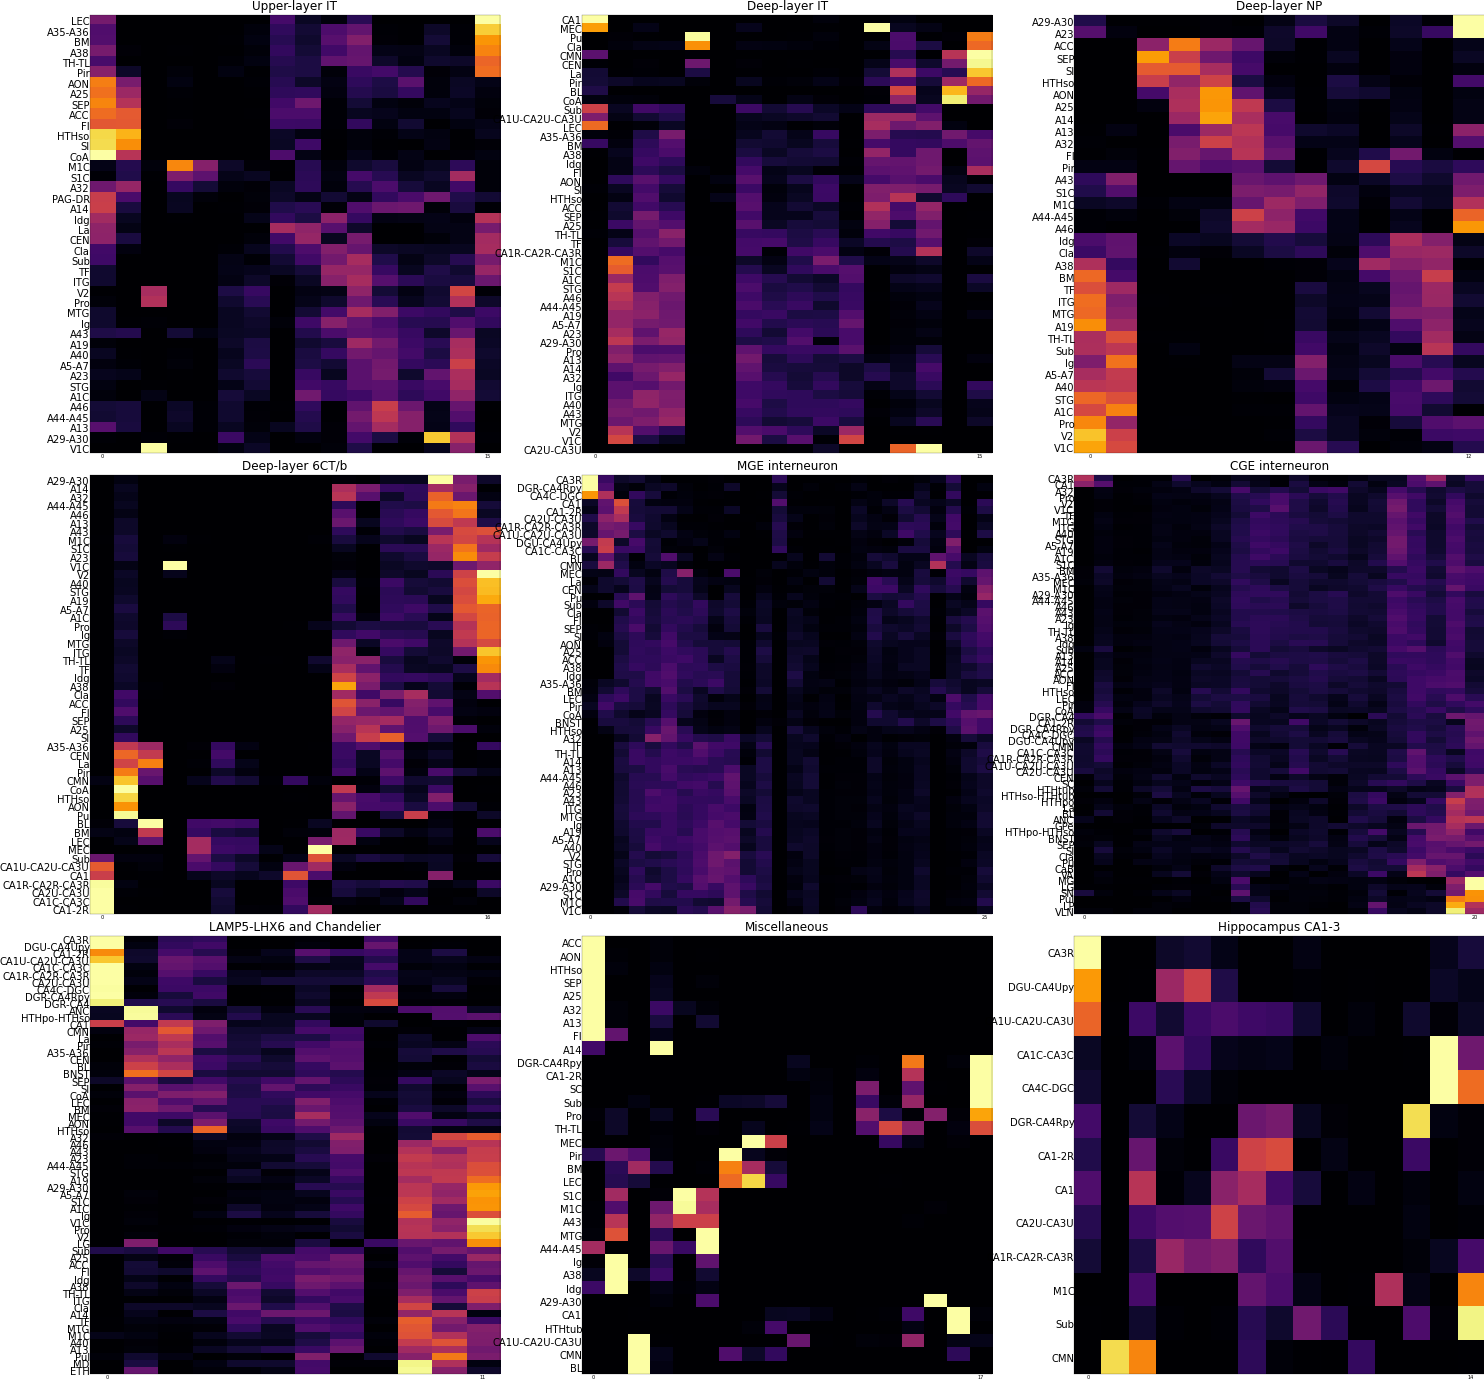

In [21]:
plt.figure(None, (25, 25))
gs = plt.GridSpec(3, 3, hspace=0.05)

i = 0

for name in superclusters[::-1][:9]:
    
    comp_mat = comp_mat_dict[name]
    rois = roi_dict[name]

    D = pdist(comp_mat, 'euclidean')
    Z = hc.linkage(D, 'complete', optimal_ordering=True)
    row_ordering = hc.leaves_list(Z)
    D = pdist(comp_mat.T, 'euclidean')
    Z = hc.linkage(D, 'complete', optimal_ordering=True)
    col_ordering = hc.leaves_list(Z)
    
    ax = plt.subplot(gs[i])
    plt.imshow(comp_mat[row_ordering][:, col_ordering], vmax=0.5, aspect='auto', interpolation='nearest', cmap='inferno')
    ax.tick_params(length=0)
    plt.xticks([0, comp_mat.shape[1] - 1], fontsize=5, ha='center')
    plt.yticks(range(len(rois)), pd.Series(rois[row_ordering]).str.replace("Human ", ""))
    plt.title(name, fontsize=12)
    plt.tight_layout()
    
    i += 1

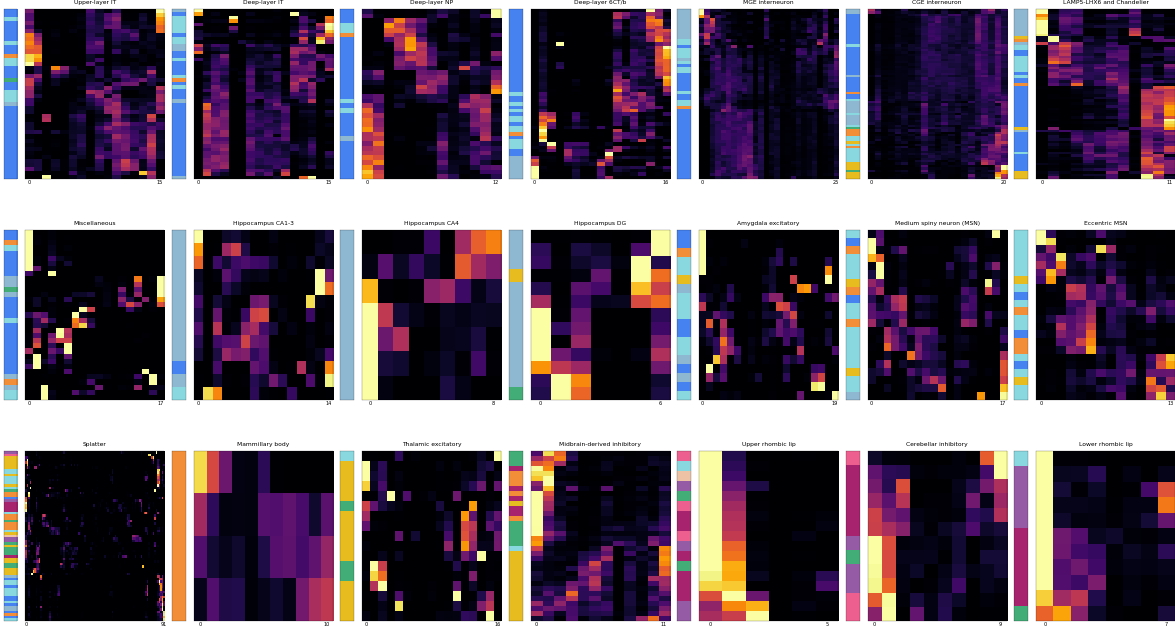

In [22]:
scale = 3
plt.figure(None, (7 * scale, 3.75 * scale))
gs = plt.GridSpec(3, 14, wspace=0.1, hspace=0.3, width_ratios=[1, 10] * 7)

i = 0

for name in superclusters[::-1]:
    
    comp_mat = comp_mat_dict[name]
    rois = roi_dict[name]

    # temp = roi_order[np.isin(roi_order, rois)]
    # row_ordering = np.array([np.where(rois == x)[0][0] for x in temp])
    
    metric = 'euclidean'
    linkage = 'complete'
    
    D = pdist(comp_mat, metric)
    Z = hc.linkage(D, linkage, optimal_ordering=True)
    row_ordering = hc.leaves_list(Z)
    D = pdist(comp_mat.T, metric)
    Z = hc.linkage(D, linkage, optimal_ordering=True)
    col_ordering = hc.leaves_list(Z)

    colors = np.array([to_rgb(region_color_dict[roi_group_dict[x]]) for x in rois[row_ordering]])
    ax = plt.subplot(gs[i])
    plt.imshow(np.expand_dims(colors, axis=1), aspect='auto', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[i+1])
    plt.imshow(comp_mat[row_ordering][:, col_ordering], vmax=0.5, aspect='auto', interpolation='nearest', cmap='inferno')
    ax.tick_params(length=0)
    plt.xticks([0, comp_mat.shape[1] - 1], fontsize=5, ha='center')
    plt.yticks([])
    plt.title(name, fontsize=6)
    
    i += 2

plt.savefig(f'{figure_folder}/supercluster_cluster_roi_heatmaps.pdf', dpi=300)


# In how many dissections are most clusters found?

In [23]:
superclass_color_dict = dict(
    zip(
        [
            'Astrocyte', 'Bergmann glia', 'CGE interneuron', 'Cerebellar inhibitory', 'Choroid plexus', 'Eccentric MSN', 'Ependymal', 'Amygdala excitatory',
            'Splatter', 'Lower rhombic lip', 'Hippocampus CA1-3', 'Hippocampus CA4', 'Hippocampus DG', 'Microglia', 'Upper-layer IT',
            'Deep-layer IT', 'Deep-layer NP', 'Deep-layer 6CT/b', 'LAMP5-LHX6 and Chandelier', 'MGE interneuron', 'Medium spiny neuron (MSN)', 'Mammillary body', 
            'Midbrain-derived inhibitory', 'Miscellaneous',
            'Oligodendrocyte precursor', 'Oligodendrocyte', 'Committed oligodendrocyte precursor',
            'Upper rhombic lip', 'Thalamic excitatory', 'Fibroblast', 'Vascular'
        ],
        [
            '#ab3bc4', '#e7c31f', '#983f00', '#4c005c', '#005c31', '#2bcd48', '#ed5f8e', '#808080', '#93feb4', '#8e7c00', '#9ccb00', '#c10087', '#003380',
            '#fea305', '#fea7ba', '#426600', '#ee1010', '#5ef0f1', '#00988e', '#dffe66', '#740afe', '#980000', '#fefe80', '#fefe00', '#0098d4', '#9cba19', '#7caa09',
            '#80baed', '#cc9f80', '#c48351', '#e12e12'
        ]
    )
)

In [24]:
# set threshold for what proportion of a cluster a dissection needs to contain to consider the cluster "in" that dissection
thresh_in = 0.05

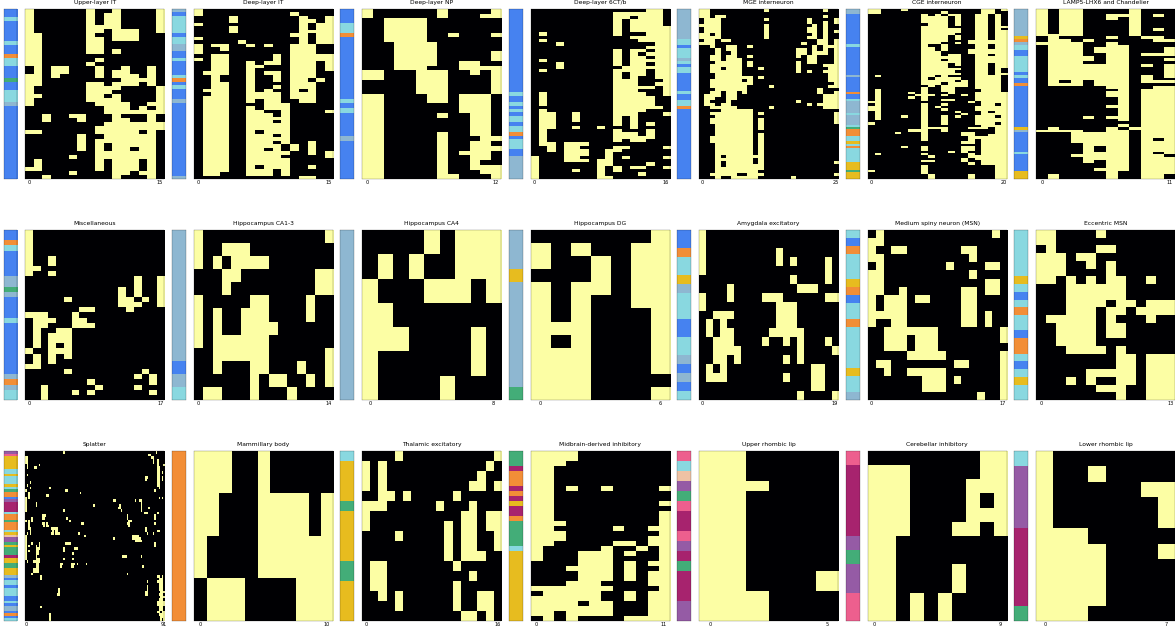

In [25]:
scale = 3
plt.figure(None, (7 * scale, 3.75 * scale))
gs = plt.GridSpec(3, 14, wspace=0.1, hspace=0.3, width_ratios=[1, 10] * 7)

i = 0

for name in superclusters[::-1]:
    
    comp_mat = comp_mat_dict[name]
    rois = roi_dict[name]

    metric = 'euclidean'
    linkage = 'complete'
    
    D = pdist(comp_mat, metric)
    Z = hc.linkage(D, linkage, optimal_ordering=True)
    row_ordering = hc.leaves_list(Z)
    D = pdist(comp_mat.T, metric)
    Z = hc.linkage(D, linkage, optimal_ordering=True)
    col_ordering = hc.leaves_list(Z)

    colors = np.array([to_rgb(region_color_dict[roi_group_dict[x]]) for x in rois[row_ordering]])
    ax = plt.subplot(gs[i])
    plt.imshow(np.expand_dims(colors, axis=1), aspect='auto', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[i+1])
    plt.imshow(comp_mat[row_ordering][:, col_ordering] > thresh_in, vmax=0.5, aspect='auto', interpolation='nearest', cmap='inferno')
    ax.tick_params(length=0)
    plt.xticks([0, comp_mat.shape[1] - 1], fontsize=5, ha='center')
    plt.yticks([])
    plt.title(name, fontsize=6)
    
    i += 2

# plt.savefig(f'{figure_folder}/supercluster_cluster_roi_heatmaps.pdf', dpi=300


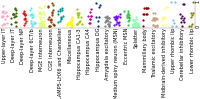

In [26]:
plt.figure(None, (3.5, 0.5))
ax = plt.subplot(111)

i = 0
width = 0.3
s = 5

for name in superclusters[::-1]:
    
    comp_mat = comp_mat_dict[name]
    rois = roi_dict[name]
    
    clust_nnz = np.count_nonzero(comp_mat > thresh_in, axis=0) / comp_mat.shape[0]
    
    x = np.array([i] * len(clust_nnz))
    plt.scatter(
        np.random.uniform(x - width, i + width), 
        clust_nnz,
        s=s,
        lw=0,
        color=superclass_color_dict[name],
        rasterized=True
    )
    
    plt.margins(0.01, 0.05)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=90)
    
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.tick_params(length=0)
    ax.yaxis.tick_right()
    
    i += 1
    
plt.xticks(range(len(superclusters)), superclusters[::-1], rotation=90, fontsize=5)
plt.yticks([0, 1], fontsize=5)
plt.savefig(f'{figure_folder}/supercluster_cluster_nnz.pdf', dpi=300)

# Region graphs

In [27]:
region_comp_mat_dict = {}
region_roi_dict = {}

for region in ['Cerebral cortex', 'Cerebral nuclei', 'Thalamus']:
            
    with loompy.connect(folder + 'Pool.loom', 'r') as ds:
        region_rois = np.unique(clean_roi(ds.ca.Roi)[ds.ca.ROIGroupCoarse == region])
        drop_rois = ['Human A35r']
        region_rois = region_rois[~np.isin(region_rois, drop_rois)]
    
    pool_file = '/proj/human_adult/20220222/harmony/paris_top_bug/data/Pool.loom'
    comp_mat = calc_comp(pool_file, rois=region_rois, drop_zeros=True, verbose=True)
    
    region_comp_mat_dict[region] = comp_mat
    region_roi_dict[region] = region_rois

Using 33 dissections: ['Human A13' 'Human A14' 'Human A19' 'Human A1C' 'Human A23' 'Human A25'
 'Human A29-A30' 'Human A32' 'Human A35-A36' 'Human A38' 'Human A40'
 'Human A43' 'Human A44-A45' 'Human A46' 'Human A5-A7' 'Human ACC'
 'Human AON' 'Human FI' 'Human ITG' 'Human Idg' 'Human Ig' 'Human LEC'
 'Human M1C' 'Human MEC' 'Human MTG' 'Human Pir' 'Human Pro' 'Human S1C'
 'Human STG' 'Human TF' 'Human TH-TL' 'Human V1C' 'Human V2']
Using 378 clusters: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133

In [28]:
lobe_dict = {
    'Frontal': ['A13', 'A14', 'A32', 'A44-A45', 'A46', 'M1C', 'A25', 'FI'],
    'Parietal': ['A5-A7', 'A40', 'A43', 'S1C'],
    'Limbic': ['ACC', 'A23', 'A29-A30', 'TH-TL'],
    'Occipital': ['A19', 'Pro', 'V1C', 'V2'],
    'Temporal': ['A1C', 'A38', 'ITG', 'Idg', 'Ig', 'MTG', 'STG', 'TF', 'A35-A36', 'LEC', 'MEC',  'A35r'],
    'Paleo': ['AON', 'Pir']
}
lobe_color = {
    'Frontal': cbl[0],
    'Parietal': cbl[1],
    'Limbic': cbl[2],
    'Occipital': cbl[3],
    'Temporal': cbl[4],
    'Paleo': cbl[5]
}

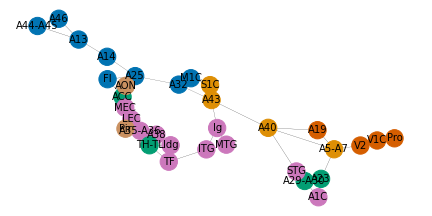

In [32]:
n_neighbors = 2
es = 5
k = 0.05

region = 'Cerebral cortex'
    
comp_mat = region_comp_mat_dict[region]
rois = region_roi_dict[region]

if region == 'Cerebral cortex':
    color_dict = {'Human ' + x:lobe_color[k] for k in lobe_dict for x in lobe_dict[k]}
    node_color = np.array([color_dict[x] for x in rois])
else:
    node_color = 'lightblue'

plt.figure(None, (6, 3))
# plt.subplot(gs[i])
dist = plot_spring_graph(comp_mat, rois, n_neighbors=n_neighbors, edge_scale=es, k=k, node_color=node_color)

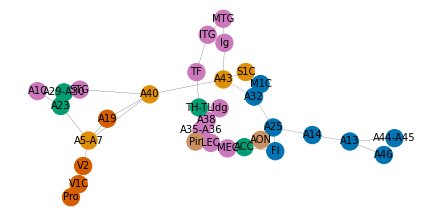

In [1206]:
n_neighbors = 2
es = 5
k = 0.05

region = 'Cerebral cortex'
    
comp_mat = region_comp_mat_dict[region]
rois = region_roi_dict[region]

if region == 'Cerebral cortex':
    color_dict = {'Human ' + x:lobe_color[k] for k in lobe_dict for x in lobe_dict[k]}
    node_color = np.array([color_dict[x] for x in rois])
else:
    node_color = 'lightblue'

plt.figure(None, (6, 3))
# plt.subplot(gs[i])
dist = plot_spring_graph(comp_mat, rois, n_neighbors=n_neighbors, edge_scale=es, k=k, node_color=node_color)

plt.savefig(f'{figure_folder}/supercluster_roi_graphs_{region}.pdf', dpi=300)

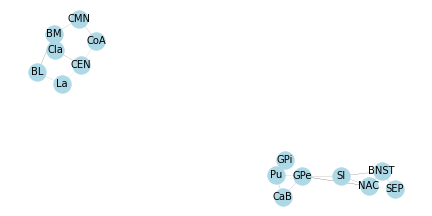

In [30]:
n_neighbors = 2
es = 5
k = 0.05

region = 'Cerebral nuclei'
    
comp_mat = region_comp_mat_dict[region]
rois = region_roi_dict[region]

if region == 'Cerebral cortex':
    color_dict = {'Human ' + x:lobe_color[k] for k in lobe_dict for x in lobe_dict[k]}
    node_color = np.array([color_dict[x] for x in rois])
else:
    node_color = 'lightblue'

plt.figure(None, (6, 3))
# plt.subplot(gs[i])
dist = plot_spring_graph(comp_mat, rois, n_neighbors=n_neighbors, edge_scale=es, k=k, node_color=node_color)

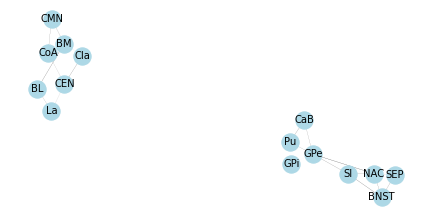

In [1300]:
n_neighbors = 2
es = 5
k = 0.2

region = 'Cerebral nuclei'
    
comp_mat = region_comp_mat_dict[region]
rois = region_roi_dict[region]

if region == 'Cerebral cortex':
    color_dict = {'Human ' + x:lobe_color[k] for k in lobe_dict for x in lobe_dict[k]}
    node_color = np.array([color_dict[x] for x in rois])
else:
    node_color = 'lightblue'

plt.figure(None, (6, 3))
# plt.subplot(gs[i])
dist = plot_spring_graph(comp_mat, rois, n_neighbors=n_neighbors, edge_scale=es, k=k, node_color=node_color)

plt.savefig(f'{figure_folder}/supercluster_roi_graphs_{region}.pdf', dpi=300)

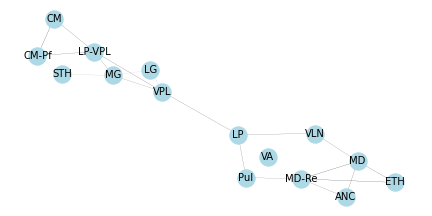

In [31]:
n_neighbors = 2
es = 5
k = 0.05

region = 'Thalamus'
    
comp_mat = region_comp_mat_dict[region]
rois = region_roi_dict[region]

if region == 'Cerebral cortex':
    color_dict = {'Human ' + x:lobe_color[k] for k in lobe_dict for x in lobe_dict[k]}
    node_color = np.array([color_dict[x] for x in rois])
else:
    node_color = 'lightblue'

plt.figure(None, (6, 3))
# plt.subplot(gs[i])
dist = plot_spring_graph(comp_mat, rois, n_neighbors=n_neighbors, edge_scale=es, k=k, node_color=node_color)

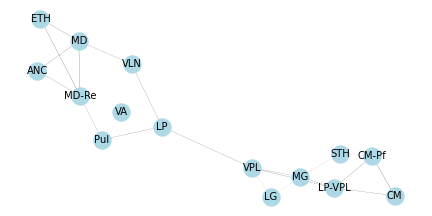

In [1301]:
n_neighbors = 2
es = 5
k = 0.2

region = 'Thalamus'
    
comp_mat = region_comp_mat_dict[region]
rois = region_roi_dict[region]

if region == 'Cerebral cortex':
    color_dict = {'Human ' + x:lobe_color[k] for k in lobe_dict for x in lobe_dict[k]}
    node_color = np.array([color_dict[x] for x in rois])
else:
    node_color = 'lightblue'

plt.figure(None, (6, 3))
# plt.subplot(gs[i])
dist = plot_spring_graph(comp_mat, rois, n_neighbors=n_neighbors, edge_scale=es, k=k, node_color=node_color)

plt.savefig(f'{figure_folder}/supercluster_roi_graphs_{region}.pdf', dpi=300)

# How much do distributions differ between superclusters?

In [33]:
cortical_rois = ['Human ' + x for x in [
    'A13', 'A14', 'A25', 'A32', 'A44-A45', 'A46', 'FI', 'M1C', # frontal cortex
    'ACC', 'A23', 'A29-A30', 'TH-TL', # limbic cortex
    'A5-A7', 'A40', 'A43', 'S1C', # parietal cortex 
    'A19', 'Pro', 'V1C', 'V2', # occipital,
    'A1C', 'A35-A36', 'A38', 'ITG', 'Idg', 'Ig', 'MTG', 'STG', 'TF', 'LEC', 'MEC', # temporal cortex,
    'AON', 'Pir'
]]

In [34]:
pool_file = '/proj/human_adult/20220222/harmony/paris_top_bug/data/Pool.loom'
cortex_comp_mat_dict = {}

i = 0

for name in ['LAMP5-LHX6 and Chandelier', 'CGE interneuron',
       'MGE interneuron', 'Deep-layer 6CT/b', 'Deep-layer NP',
       'Deep-layer IT', 'Upper-layer IT'][::-1]:
    
    print(f'\n{name}')
    
    subset = supercluster_dict[name]
            
    with loompy.connect(pool_file, 'r') as ds:
        cluster_set = np.unique(ds.ca.Clusters[ds.ca.Punchcard == subset])
            
    comp_mat = calc_comp(pool_file, rois=cortical_rois, cluster_set=cluster_set, drop_zeros=True, verbose=True)
    
    cortex_comp_mat_dict[name] = comp_mat

    i += 1


Upper-layer IT
Using 33 dissections: ['Human A13', 'Human A14', 'Human A25', 'Human A32', 'Human A44-A45', 'Human A46', 'Human FI', 'Human M1C', 'Human ACC', 'Human A23', 'Human A29-A30', 'Human TH-TL', 'Human A5-A7', 'Human A40', 'Human A43', 'Human S1C', 'Human A19', 'Human Pro', 'Human V1C', 'Human V2', 'Human A1C', 'Human A35-A36', 'Human A38', 'Human ITG', 'Human Idg', 'Human Ig', 'Human MTG', 'Human STG', 'Human TF', 'Human LEC', 'Human MEC', 'Human AON', 'Human Pir']
Using 16 clusters: [291 292 293 302 303 304 305 306 307 308 309 310 311 312 313 314]

Deep-layer IT
Using 33 dissections: ['Human A13', 'Human A14', 'Human A25', 'Human A32', 'Human A44-A45', 'Human A46', 'Human FI', 'Human M1C', 'Human ACC', 'Human A23', 'Human A29-A30', 'Human TH-TL', 'Human A5-A7', 'Human A40', 'Human A43', 'Human S1C', 'Human A19', 'Human Pro', 'Human V1C', 'Human V2', 'Human A1C', 'Human A35-A36', 'Human A38', 'Human ITG', 'Human Idg', 'Human Ig', 'Human MTG', 'Human STG', 'Human TF', 'Human L

/proj/user/kimberly/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/proj/user/kimberly/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


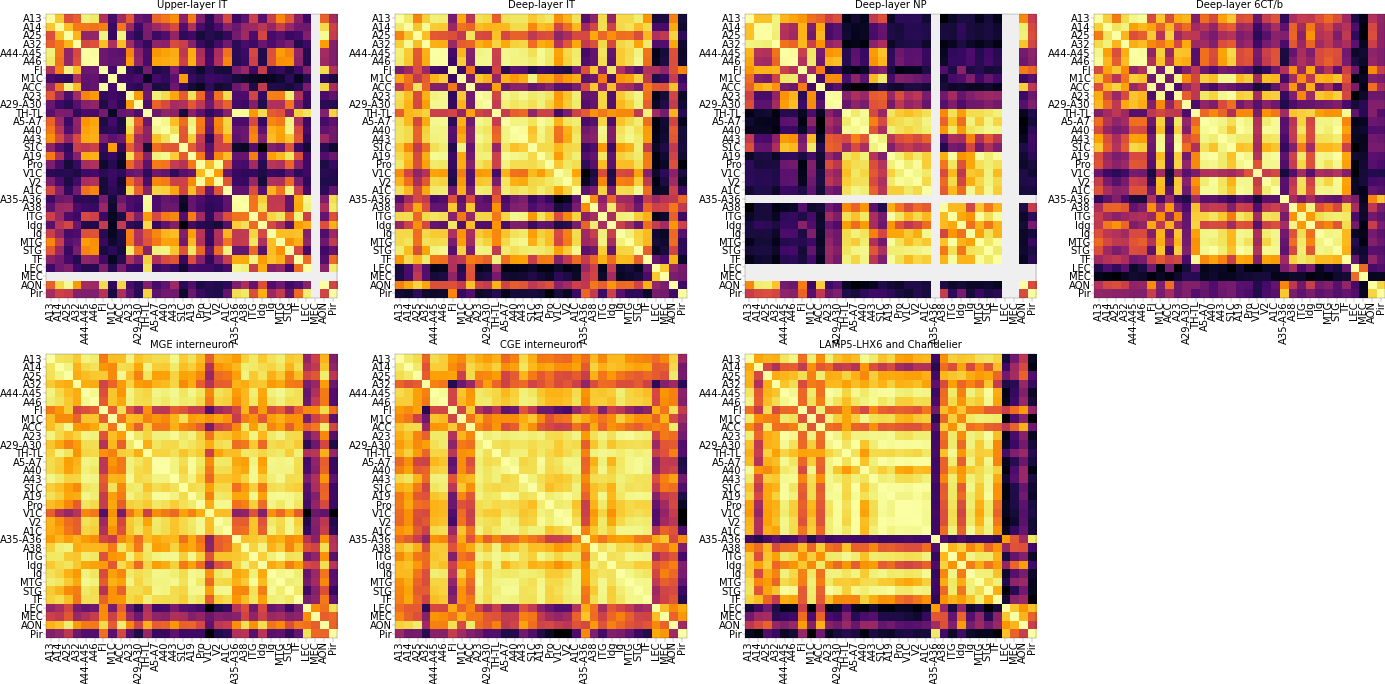

In [35]:
plt.figure(None, (24, 24))
gs = plt.GridSpec(4, 4)

i = 0

for name in ['LAMP5-LHX6 and Chandelier', 'CGE interneuron',
       'MGE interneuron', 'Deep-layer 6CT/b', 'Deep-layer NP',
       'Deep-layer IT', 'Upper-layer IT'][::-1]:
    
    comp_mat = cortex_comp_mat_dict[name]
    
    D = np.corrcoef(comp_mat)
    plt.subplot(gs[i])
    plt.imshow(np.zeros(D.shape), cmap='Pastel2_r', alpha=0.30)
    plt.imshow(D, aspect='auto', cmap='inferno', interpolation='nearest')
    plt.title(name, fontsize=10)
    plt.xticks(range(len(cortical_rois)), pd.Series(cortical_rois).str.replace('Human ', ''), rotation=90)
    plt.yticks(range(len(cortical_rois)), pd.Series(cortical_rois).str.replace('Human ', ''))
    
    i += 1

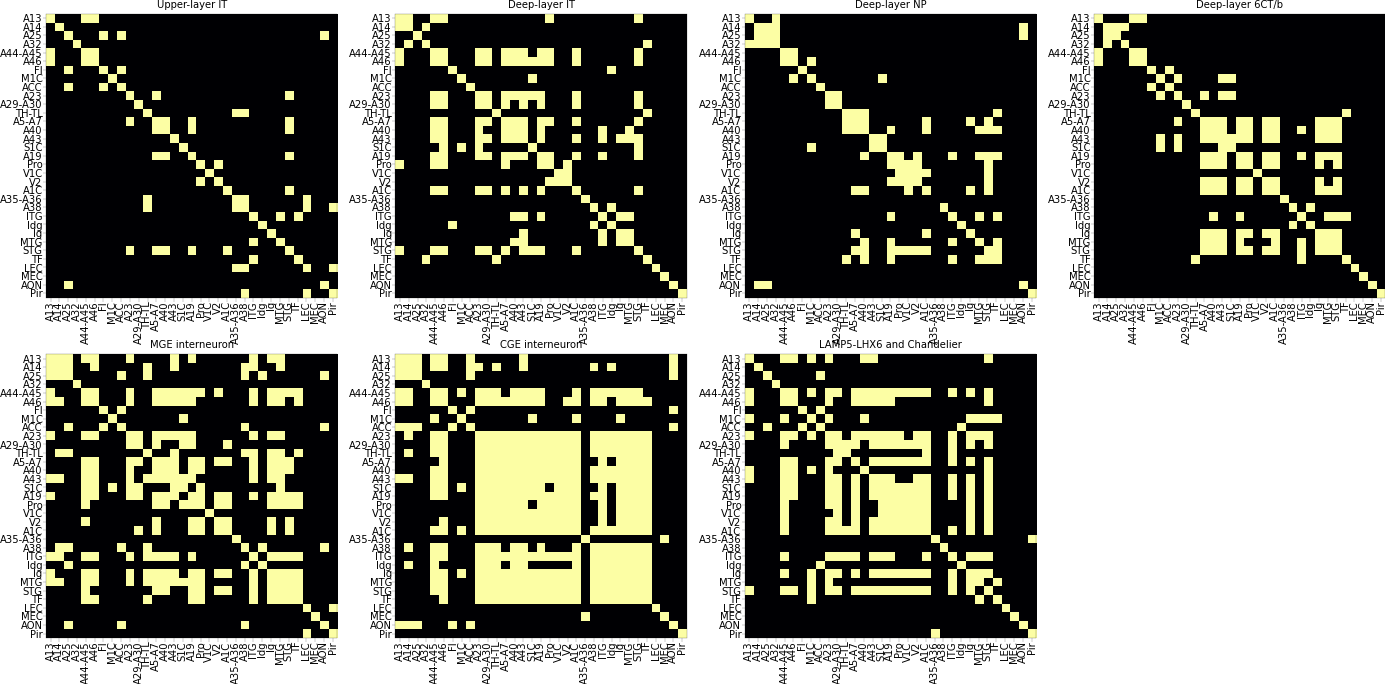

In [36]:
plt.figure(None, (24, 24))
gs = plt.GridSpec(4, 4)

i = 0

for name in ['LAMP5-LHX6 and Chandelier', 'CGE interneuron',
       'MGE interneuron', 'Deep-layer 6CT/b', 'Deep-layer NP',
       'Deep-layer IT', 'Upper-layer IT'][::-1]:
    
    comp_mat = cortex_comp_mat_dict[name]
    
    D = np.corrcoef(comp_mat)
    plt.subplot(gs[i])
    plt.imshow(np.zeros(D.shape), cmap='Pastel2_r', alpha=0.30)
    plt.imshow(D > 0.9, aspect='auto', cmap='inferno', interpolation='nearest')
    plt.title(name, fontsize=10)
    plt.xticks(range(len(cortical_rois)), pd.Series(cortical_rois).str.replace('Human ', ''), rotation=90)
    plt.yticks(range(len(cortical_rois)), pd.Series(cortical_rois).str.replace('Human ', ''))
    
    i += 1

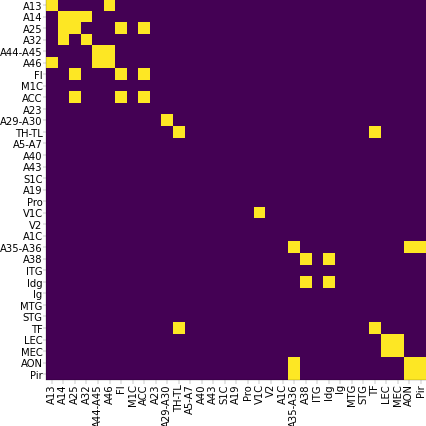

In [37]:
X = np.corrcoef(cortex_comp_mat_dict['Deep-layer 6CT/b'])

def std_masked_corrmat(mat, n_std):
    avg = np.mean(mat, axis=0)
    std = np.std(mat, axis=0)
    out = (mat - avg) >= std * n_std
    out = out * out.T
    return out

plt.figure(None, (7, 7))
plt.imshow(std_masked_corrmat(X, 1.5))
plt.xticks(range(len(cortical_rois)), pd.Series(cortical_rois).str.replace('Human ', ''), rotation=90)
plt.yticks(range(len(cortical_rois)), pd.Series(cortical_rois).str.replace('Human ', ''))
plt.show()

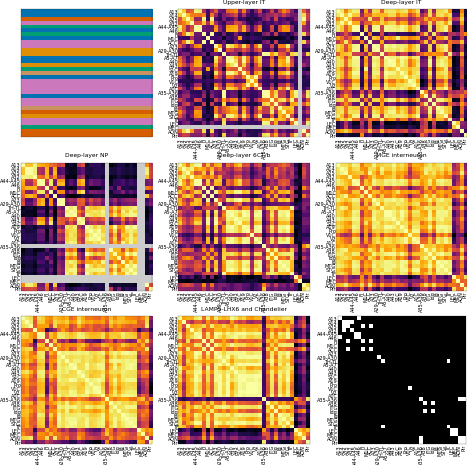

In [38]:
plt.figure(None, (8, 8))
gs = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)

color_dict = {'Human ' + x:lobe_color[k] for k in lobe_dict for x in lobe_dict[k]}
colors = np.array([color_dict[x] for x in rois])
ax = plt.subplot(gs[0])
plt.imshow(np.expand_dims(colors, axis=1), aspect='auto', interpolation='nearest')
plt.xticks([])
plt.yticks([])

i = 1

for name in ['LAMP5-LHX6 and Chandelier', 'CGE interneuron',
       'MGE interneuron', 'Deep-layer 6CT/b', 'Deep-layer NP',
       'Deep-layer IT', 'Upper-layer IT'][::-1]:
    
    comp_mat = cortex_comp_mat_dict[name]
    rois = cortical_rois
        
    D = np.corrcoef(comp_mat)
    ax = plt.subplot(gs[i])
    plt.imshow(np.zeros(D.shape), cmap='Pastel2_r')
    plt.imshow(D, aspect='auto', interpolation='nearest', cmap='inferno')
    ax.tick_params(length=0)
    plt.xticks(range(len(cortical_rois)), pd.Series(cortical_rois).str.replace('Human ', ''), rotation=90, fontsize=5)
    plt.yticks(range(len(cortical_rois)), pd.Series(cortical_rois).str.replace('Human ', ''), fontsize=5)
    plt.title(name, fontsize=6)
    
    i += 1

ax = plt.subplot(gs[i])
plt.imshow(std_masked_corrmat(X, 1.5), cmap='Greys_r')
ax.tick_params(length=0)
plt.xticks(range(len(cortical_rois)), pd.Series(cortical_rois).str.replace('Human ', ''), rotation=90, fontsize=5)
plt.yticks(range(len(cortical_rois)), pd.Series(cortical_rois).str.replace('Human ', ''), fontsize=5)

plt.savefig(f'{figure_folder}/supercluster_roi_heatmaps_supp.pdf', dpi=300)